Agatha Justina Majcher  
M.Sc. Renewable Energy Systems

# Distributional Analysis of the Carbon Tax in South Africa

Part II - PyPSA-ZA  
Revenue Recycling through Investment in Renewable Energies

# 1. Setup

In [1]:
import sys
sys.path.append("~/Desktop/pypsa-za-master")

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("bmh")
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import numpy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from vresutils import plot as vplot
from vresutils import Dict

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# setup for plots
colors = {
    "onwind": "#77D1E4",
    "hydro": "#004F95",
    "hydro-import": "#004F95",
    "CSP": "#FEED82",
    "solar": "#FFBB4E",
    "biomass": "#0c6013",
    "CCGT": "#CCC8C8",
    "OCGT": "#8D7867",
    "nuclear": "#C84936",
    "gas": "grey",
    "coal": "#3C3C3C",
}

nice_names = {
    'nuclear': 'Nuclear',
    'coal': 'Coal',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'gas': 'Gas',
    'onwind': 'Wind',
    'hydro': 'Hydro',
    'hydro-import': 'Hydro Import',
    'solar': 'PV',
    'CSP': 'CSP',
    'biomass': 'Biomass',
}

In [184]:
# solved_network files

n275oc = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc") #2-75oc
n275wc = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275wc+.nc") #2-75wc 
n96 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_96oc.nc") #9-6

n8 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-8.nc") #8


INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275wc+.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_96oc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [8]:
n8 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-8.nc") #8


INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H-8.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [11]:
for c in n8.iterate_components(list(n8.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 27 entries
Component 'Carrier' has 12 entries
Component 'GlobalConstraint' has 17 entries
Component 'Line' has 120 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 27 entries
Component 'Generator' has 695 entries
Component 'StorageUnit' has 328 entries


# 2. Share Renewables Energies

#### Time Series per Carrier and _t.p

In [12]:
n8.generators_t.p.sum().groupby(n8.generators.carrier).sum()

carrier
CCGT             0.000000e+00
CSP              1.986336e+06
OCGT             1.270366e+03
biomass          9.567008e+05
coal             3.054011e+07
gas              4.603900e+05
hydro            4.053793e+05
hydro-import     1.654324e+06
load_shedding    0.000000e+00
nuclear          1.025172e+07
onwind           1.831839e+08
solar            4.889680e+07
dtype: float64

In [199]:
gen_n275oc=n275oc.generators_t.p.sum().groupby(n275oc.generators.carrier).sum()

In [200]:
gen_n275oc.to_csv('gen_n275oc.csv', index=True)

In [201]:
n275wc.generators_t.p.sum().groupby(n275wc.generators.carrier).sum()

carrier
CCGT             0.000000e+00
CSP              1.986336e+06
OCGT             7.951505e+05
biomass          9.567008e+05
coal             1.657682e+08
gas              5.236794e+05
hydro            5.137411e+06
hydro-import     1.013829e+07
load_shedding    0.000000e+00
nuclear          1.357096e+07
onwind           4.442807e+07
solar            3.483823e+07
dtype: float64

In [202]:
gen_n275wc=n275oc.generators_t.p.sum().groupby(n275wc.generators.carrier).sum()

In [203]:
gen_n275wc.to_csv('gen_n275wc.csv', index=True)

In [207]:
n96.generators_t.p.sum().groupby(n96.generators.carrier).sum()

carrier
CCGT             0.000000e+00
CSP              1.986336e+06
OCGT             2.425088e+05
biomass          9.567008e+05
coal             1.017557e+08
gas              4.859458e+05
hydro            4.960680e+06
hydro-import     9.730947e+06
load_shedding    0.000000e+00
nuclear          1.344281e+07
onwind           9.553330e+07
solar            4.925683e+07
dtype: float64

In [205]:
gen_n96.to_csv('gen_n96.csv', index=True)

In [13]:
# Total generation in GW
n8.generators_t.p.sum().sum()/8760/1e3

31.773619837283626

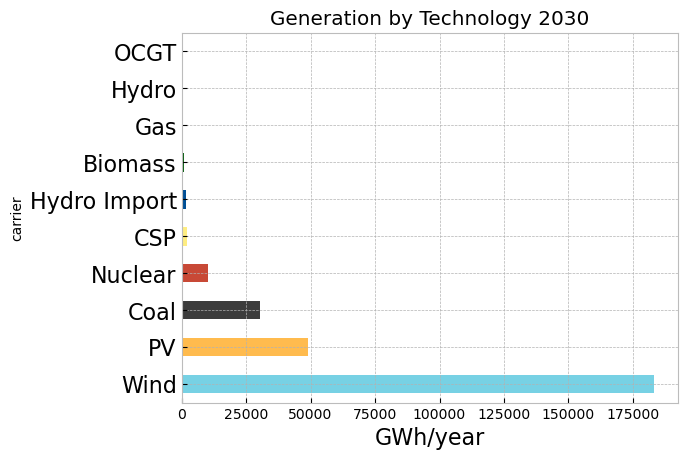

In [15]:
# Group by carrier and sum p_nom, divide by 1000 to convert to GW
a = n8.generators_t.p.sum().groupby(n8.generators.carrier).sum().div(1e3)
a = a[a != 0] 

carrier_order = ['onwind', 'solar', 'CSP', 'hydro', 'hydro-import', 'biomass', 'gas', 'OCGT', 'nuclear', 'coal']
a_sorted = a.loc[carrier_order].sort_values(ascending=False)

# Create horizontal bar chart
ax = a_sorted.plot.barh(color=[colors.get(carrier, '#333333') for carrier in a_sorted.index])
ax.set_xlabel('GWh/year', fontsize=16)
ax.set_title('Generation by Technology 2030')

ax.set_facecolor('white')

# Replace carrier names with nice names
ax.set_yticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()],fontsize=16)

# Save plot as PNG with descriptive file name
plt.savefig('n8.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

#### Generated Electricity per Day

In [16]:
# power (MWh) sum of 8760h /24 - MWh per day /1000 - GW per day
p_by_carrier = n8.generators_t.p.groupby(n8.generators.carrier, axis=1).sum()
p_by_carrier = p_by_carrier.droplevel(level='period')
p_by_carrier = p_by_carrier.drop(columns=["load_shedding"])

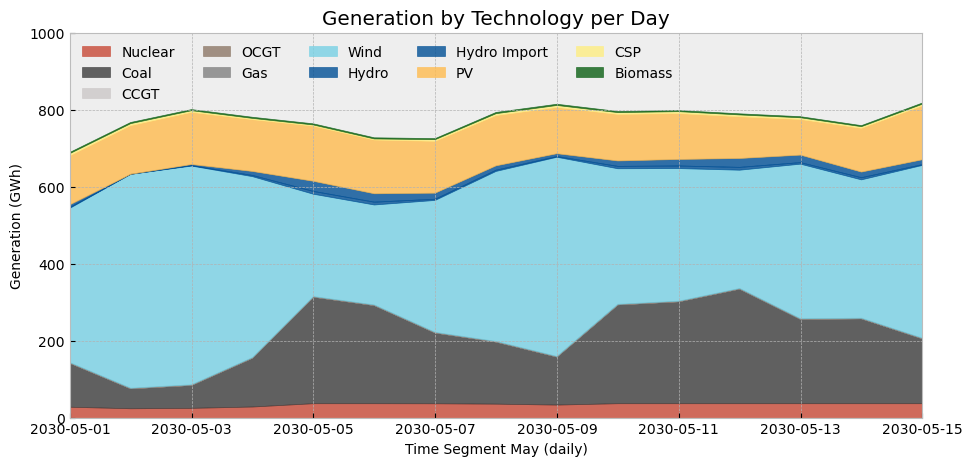

In [41]:
p_by_carrier_resampled = p_by_carrier.resample("D").sum()/1e3
stacked = p_by_carrier_resampled.stack().reset_index()
stacked.columns = ['week', 'carrier', 'GW']
stacked = stacked.pivot(index='week', columns='carrier', values='GW')
bottom = 0


fig, ax = plt.subplots(figsize=(11, 5))
bottom = 0
for carrier in nice_names:
    data = stacked[carrier]
    ax.fill_between(
        data.index, bottom, bottom + data, 
        color=colors[carrier], alpha=0.8, label=nice_names[carrier]
    )
    bottom += data

# add legend and axis labels
ax.set_xlim(pd.Timestamp('2030-05-01'), pd.Timestamp('2030-05-15'))
ax.legend(ncol=5, loc="upper left", frameon=False)
ax.set_xlabel("Time Segment May (daily)")
ax.set_ylabel("Generation (GWh)")
ax.set_title("Generation by Technology per Day")
ax.set_ylim(0,1000);

# Save plot as PNG
plt.savefig('time_generation8.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

In [22]:
# Group generator capacities by carrier before optimization
#gen_capacities_by_carrier_before = n275oc.generators.groupby('carrier')['p_nom'].sum()

# Group generator capacities by carrier after optimization
gen_capacities_by_carrier_after = n8.generators.groupby('carrier')['p_nom_opt'].sum()

# Display the grouped generator capacities before and after optimization
print("Generator capacities by carrier before optimization:")
#print(gen_capacities_by_carrier_before)

print("\nGenerator capacities by carrier after optimization:")
print(gen_capacities_by_carrier_after)


Generator capacities by carrier before optimization:

Generator capacities by carrier after optimization:
carrier
CCGT             0.000000e+00
CSP              6.000000e+02
OCGT             6.986096e+03
biomass          1.930600e+02
coal             4.028400e+04
gas              3.844000e+03
hydro            6.830200e+02
hydro-import     1.764000e+03
load_shedding    2.700000e+07
nuclear          1.854000e+03
onwind           6.796996e+04
solar            2.609595e+04
Name: p_nom_opt, dtype: float64


In [373]:
#### Storage Unit

In [24]:
a = n8.storage_units_t.p.sum()
a = a.loc[a != 0]
a.head(20)

StorageUnit
BLOEMFONTEIN battery_2020    -5.252284e-12
BLOEMFONTEIN battery_2022     5.915149e-12
BLOEMFONTEIN battery_2024    -5.284562e-12
BLOEMFONTEIN battery_2026     8.884771e-12
BLOEMFONTEIN battery_2028     1.383632e-11
BLOEMFONTEIN battery_2030     9.487451e-12
CARLETONVILLE battery_2020   -5.466240e-11
CARLETONVILLE battery_2022   -4.885014e-11
CARLETONVILLE battery_2024   -3.490015e-11
CARLETONVILLE battery_2026    2.921609e-12
CARLETONVILLE battery_2028   -1.561624e-11
CARLETONVILLE battery_2030   -9.067091e-12
Drakensberg                  -4.085505e+05
EAST LONDON battery_2020     -3.713683e-12
EAST LONDON battery_2022     -1.119368e-11
EAST LONDON battery_2024      5.777792e-13
EAST LONDON battery_2026      1.550610e-10
EAST LONDON battery_2028     -1.751371e-11
EAST LONDON battery_2030      2.982421e-11
EMPANGENI battery_2020        9.221467e-11
dtype: float64

In [163]:
a = n275wc.storage_units_t.p.sum()
a = a.loc[a != 0]
a.sum()

-1182522.728590638

In [25]:
b= n8.storage_units.p_nom_opt
b= b.loc[b != 0]
b

StorageUnit
Drakensberg    1000.0
Ingula         1332.0
Palmiet         400.0
Steenbras       180.0
Name: p_nom_opt, dtype: float64

In [26]:
b.sum()

2912.0

In [365]:
# Before optimization
storage_units_before = n96.storage_units.p_nom

# After optimization
storage_units_after = n96.storage_units.p_nom_opt

print("Total storage capacity for Storage Units before optimization:", storage_units_before.sum())
print("Total storage capacity for Storage Units after optimization:", storage_units_after.sum())


Total storage capacity for Storage Units before optimization: 2912.0
Total storage capacity for Storage Units after optimization: 2912.0


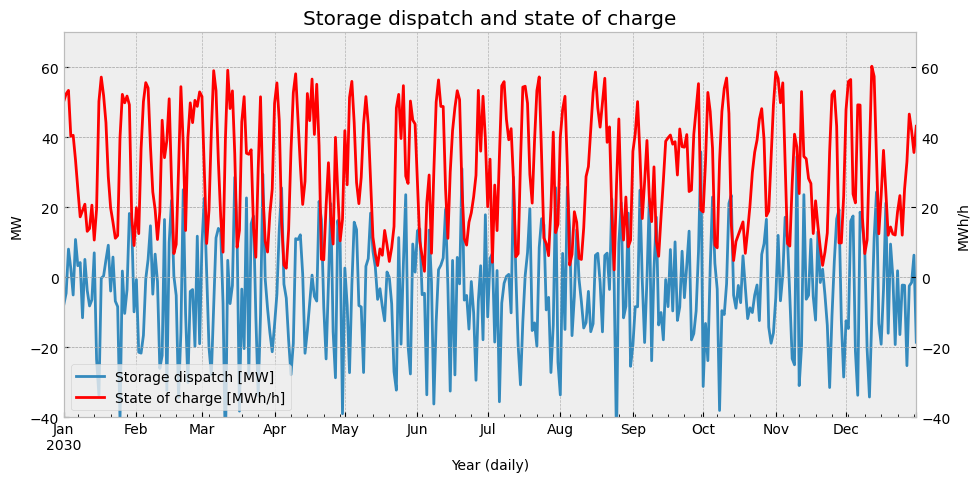

In [28]:
fig, ax = plt.subplots(figsize=(11, 5))

p_storage = n8.storage_units_t.p.sum(axis=1).div(1e3)
p_storage = p_storage.droplevel(level='period')
p_storage = p_storage.resample("D").sum()
state_of_charge = n8.storage_units_t.state_of_charge.sum(axis=1).div(1e3)/24
state_of_charge = state_of_charge.droplevel(level='period')
state_of_charge = state_of_charge.resample("D").sum()

p_storage.plot(label="Storage dispatch [MW]", ax=ax, ylabel="MW")

ax2 = ax.twinx()
ax2.plot(state_of_charge, label="State of charge [MWh/h]", color="red")
ax2.set_ylabel("MWh/h")

ax.set_ylim([-40, 70])
ax2.set_ylim([-40, 70])

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
ax.set_xlabel("Year (daily)")

ax.grid(True)
plt.title("Storage dispatch and state of charge")
plt.savefig("storage8.png")

#### Power Flow

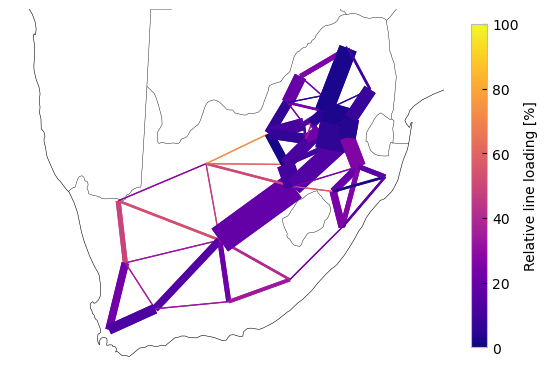

In [401]:
map_boundaries = [14, 34, -35, -22] 

line_loading = n96.lines_t.p0.iloc[0].abs() / n96.lines.s_nom_opt / n96.lines.s_max_pu * 100 # %

norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

n96.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=n96.lines.s_nom_opt/ 1000,
    boundaries=map_boundaries
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

plt.savefig("network96.png")

### Transmission Line Expansion

In [355]:
(n96.lines.s_nom_opt).head(5)

Line
0    3574.952867
1    5362.429300
2     893.738217
3     893.738217
4     893.738217
Name: s_nom_opt, dtype: float64

In [347]:
unique_line_types = n96.lines.type.unique()
print("Unique line types:", unique_line_types)


Unique line types: ['Al/St 240/40 4-bundle 380.0']


In [358]:
# Before optimization
ac_lines_before = n275oc.lines.loc[n275oc.lines.type == "Al/St 240/40 4-bundle 380.0", "s_nom"]

# After optimization
ac_lines_after = n275oc.lines.loc[n275oc.lines.type == "Al/St 240/40 4-bundle 380.0", "s_nom_opt"]


In [359]:
print("Total AC line capacity before optimization:", ac_lines_before.sum())
print("Total AC line capacity after optimization:", ac_lines_after.sum())

Total AC line capacity before optimization: 0.0
Total AC line capacity after optimization: 566633.3115725508


# 3. Total Annual System Costs in billion

In [29]:
n8.objective/1e9 

274.92729323734585

In [30]:
def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
    components = dict(
        Link=("p_nom", "p0"),
        Generator=("p_nom", "p"),
        StorageUnit=("p_nom", "p"),
        Store=("e_nom", "p"),
        Line=("s_nom", None),
        Transformer=("s_nom", None),
    )

    costs = {}
    for c, (p_nom, p_attr) in zip(
        n.iterate_components(components.keys(), skip_empty=False), components.values()
    ):
        if c.df.empty:
            continue
        if not existing_only:
            p_nom += "_opt"
        costs[(c.list_name, "capital")] = (
            (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        )
        if p_attr is not None:
            p = c.pnl[p_attr].sum()
            if c.name == "StorageUnit":
                p = p.loc[p > 0]
            costs[(c.list_name, "marginal")] = (
                (p * c.df.marginal_cost).groupby(c.df.carrier).sum()
            )
    costs = pd.concat(costs)

    if flatten:
        assert opts is not None
        conv_techs = opts["conv_techs"]

        costs = costs.reset_index(level=0, drop=True)
        costs = costs["capital"].add(
            costs["marginal"].rename({t: t + " marginal" for t in conv_techs}),
            fill_value=0.0,
        )

    return costs

In [31]:
costs_df = aggregate_costs(n8, flatten=False, opts=None, existing_only=False)


In [32]:
costs_df

                         carrier      
generators     capital   CCGT             0.000000e+00
                         CSP              6.299739e+09
                         OCGT             8.168938e+09
                         biomass          1.928387e+09
                         coal             4.478069e+10
                         gas              6.429890e+08
                         hydro            0.000000e+00
                         hydro-import     0.000000e+00
                         load_shedding    0.000000e+00
                         nuclear          2.200698e+09
                         onwind           1.233617e+11
                         solar            1.802232e+10
               marginal  CCGT             0.000000e+00
                         CSP              1.997913e+04
                         OCGT             2.198825e+06
                         biomass          9.889489e+03
                         coal             1.050806e+10
                         g

In [380]:
costs_before_optimization = aggregate_costs(n275oc, existing_only=True, use_optimized=False)
print(costs_before_optimization)


                         carrier      
generators     capital   CCGT             0.000000e+00
                         CSP              6.299739e+09
                         OCGT             0.000000e+00
                         biomass          1.928387e+09
                         coal             4.478069e+10
                         gas              6.429890e+08
                         hydro            0.000000e+00
                         hydro-import     0.000000e+00
                         load_shedding    0.000000e+00
                         nuclear          2.200698e+09
                         onwind           0.000000e+00
                         solar            0.000000e+00
               marginal  CCGT             0.000000e+00
                         CSP              2.012257e+04
                         OCGT             1.376271e+09
                         biomass          1.034813e+04
                         coal             6.215739e+10
                         g

# 4. CO2 Emissions

In [412]:
#### Total CO2 emissions by the network (efficiency and fuel source)

In [33]:
emissions = n8.generators_t.p / n8.generators.efficiency * n8.generators.carrier.map(n8.carriers.co2_emissions)
emissions.sum().sum() / 1e6 #Gt

27.53034461636932

In [34]:
e = (n8.generators_t.p/n8.generators.efficiency*n8.generators.carrier.map(n8.carriers.co2_emissions)).sum()
e_carrier = e.groupby(n8.generators.carrier).sum()/1e6

In [35]:
e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)

In [36]:
e_carrier = e_carrier.groupby('carrier').sum()

In [37]:
e_carrier

carrier
CCGT              0.000000
CSP               0.000000
biomass           0.000000
coal             27.355250
gas               0.175094
hydro             0.000000
hydro-import      0.000000
load_shedding     0.000000
nuclear           0.000000
onwind            0.000000
solar             0.000000
dtype: float64

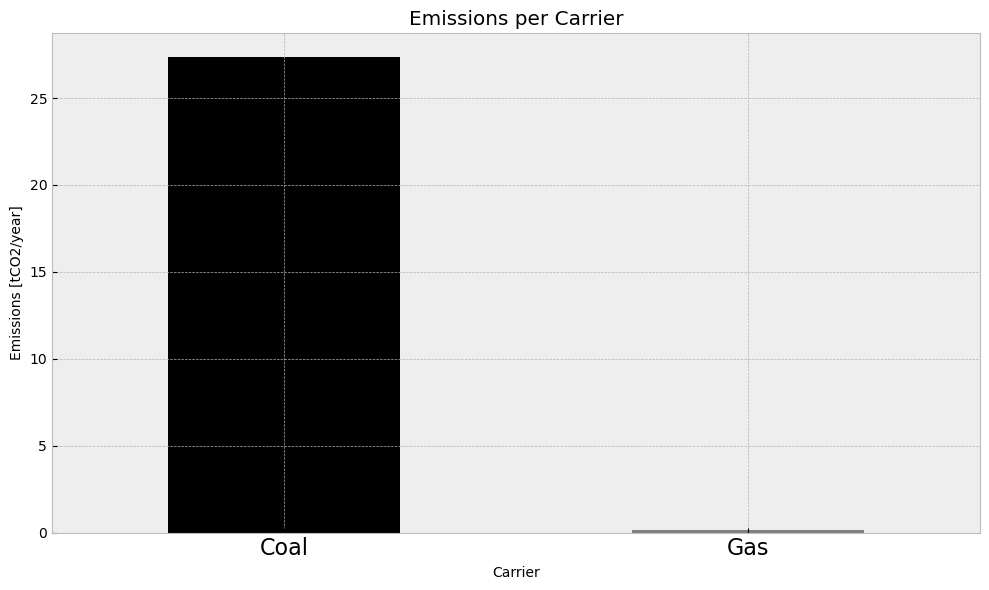

In [38]:
e_carrier = e_carrier.loc[lambda x: x != 0]

fig, ax = plt.subplots(figsize=(10, 6))
e_carrier.plot(kind="bar", ax=ax, rot=0, color=["black", "grey"])

ax.set_xlabel("Carrier")
ax.set_ylabel("Emissions [tCO2/year]")
ax.set_title("Emissions per Carrier")

ax.set_xticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()],fontsize=16)

plt.tight_layout()
plt.savefig("emissions_per_carrier8.png")

In [318]:
#### Plot total CO2 emissions per day

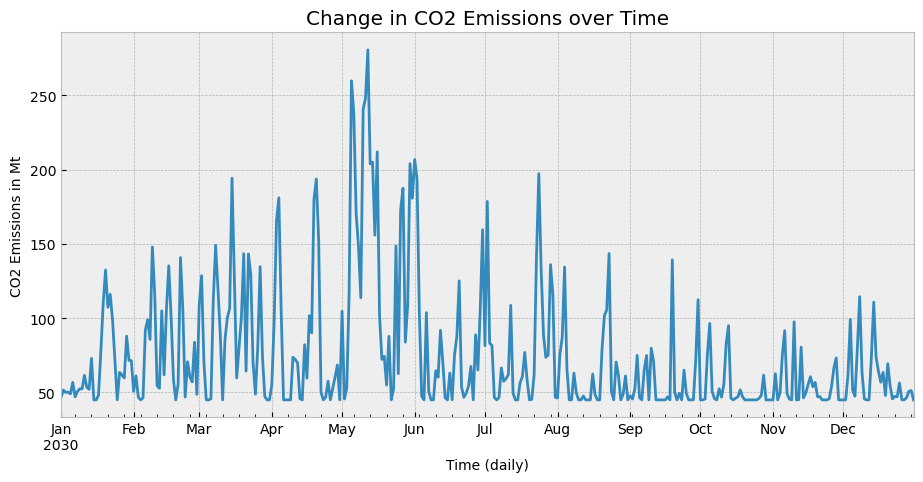

In [40]:
emissions = (n8.generators_t.p / n8.generators.efficiency * n8.generators.carrier.map(n8.carriers.co2_emissions)).sum(axis=1)
emissions = emissions.droplevel(level='period')
emissions = emissions.resample("D").sum()/1e3


emissions.plot(figsize=(11, 5), title='Change in CO2 Emissions over Time', 
               xlabel='Time (daily)', ylabel='CO2 Emissions in Mt')

plt.savefig("emissions8.png")